# Sentimental Analysis using TextBlob and HuggingFace Transformers

## Installing Transformers Libraries

In [1]:
!pip install transformers

## Importing nesscessary libraries

In [38]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
stemmer= PorterStemmer()
lemmatizer = WordNetLemmatizer()
from textblob import TextBlob
from cleantext import clean
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Neheil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Neheil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Neheil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Neheil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Reading the dataset using pandas 

In [39]:
df=pd.read_csv("Amazon_reviews.csv")
df.head(5)

,Unnamed: 0,Customer Name,Review Title,Rating,Reviews
0,0,Ashutosh singh,Mast hai,5.0 out of 5 stars,I will surprise with the quick touch response
1,1,Swati,Perfect buy,5.0 out of 5 stars,Must buy earbuds loved the bass quality and ac...
2,2,Anuragkumar,Perfect partner for lone wolf.,5.0 out of 5 stars,It got very smooth touch contel experience. Th...
3,3,Ravindra,So good,5.0 out of 5 stars,Balanced sounds in your ears without the distr...
4,4,Shubham Singh,Worth buying,5.0 out of 5 stars,This is the best earbud I have ever purchased....


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     149 non-null    int64 
 1   Customer Name  149 non-null    object
 2   Review Title   149 non-null    object
 3   Rating         149 non-null    object
 4   Reviews        145 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.9+ KB


In [5]:
df.columns

Index(['Unnamed: 0', 'Customer Name', 'Review Title', 'Rating', 'Reviews'], dtype='object')

In [40]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)

### Cleaning the raw data using nltk
### Convert it into cleaned Tokens

In [41]:
clean_reviews=[]
for index in df.index:
    review1=df.loc[index]["Reviews"]
    # cleaning the emoji 
    review=clean(review1, no_emoji=True)
    pattern=r'[0 - 9]'
    reviews=re.sub(pattern," ",review)
    # lowering the case
    reviews=reviews.lower()
    reviews=str(TextBlob(reviews).correct())
    tokens=RegexpTokenizer(r'\w+').tokenize(reviews)
    # removing the stopwords from the tokens
    cleaned_tokens=[token for token in tokens if token not in stopwords]
    # joining the cleaned tokens
    clean_data=" ".join(cleaned_tokens)
    clean_reviews.append(clean_data)


### Using the textblob analysis the sentiment of the review

In [60]:
def blob_sentiment(clean_reviews):
    sentiment=[]
    for review in clean_reviews:
        analysis=TextBlob(review)
        if analysis.sentiment.polarity>0:
            sentiment.append('positve')
        elif analysis.sentiment.polarity==0:
            sentiment.append('neutral')
        else:
            sentiment.append('negetive')
    return sentiment      

### Create a Column in the dataframe for the Textblob sentiments

In [43]:
# finding the value counts of each category of analysis
df_senti=df["Blob_Sentiment"].value_counts().reset_index()
df_senti

,index,Blob_Sentiment
0,positve,106
1,neutral,27
2,negetive,16


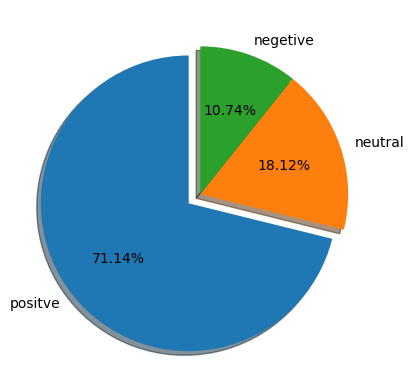

In [44]:
# ploting the value count of analysis
myexplode=[0.1,0,0]
plt.pie(df_senti["Blob_Sentiment"],labels=df_senti["index"],startangle = 90,explode=myexplode,shadow=True,autopct='%1.2f%%')
plt.show()

## Analysis the sentiment using the Roberta Pretrained model

In [45]:
# giving the model name from huggingface transformers
# autotokenizer for the roberta model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [47]:
# Process of converting cleaned tokens into the roberta probability score
def rob_sentiment(clean_reviews):
    scores=[]
    for review in clean_reviews:
        encoded_text = tokenizer(review, return_tensors='pt')
        output = model(**encoded_text)
        # deatching it from tensor
        score = output[0][0].detach().numpy()
        scores.append(score)
    return scores    

In [50]:
# Converting the numpy array into List
arr_score = rob_sentiment(clean_reviews)
scores = [array.tolist() for array in arr_score]
scores

[[-2.670201539993286, 0.7632378339767456, 2.340700149536133],
 [-2.32844877243042, 0.47861433029174805, 1.8765536546707153],
 [-2.5256776809692383, 0.5489840507507324, 2.1396636962890625],
 [-0.9885949492454529, 1.3422703742980957, -0.5451588034629822],
 [-2.461487054824829, 0.39404070377349854, 2.5211920738220215],
 [-1.496423363685608, 0.3278645873069763, 1.5011248588562012],
 [-1.247981309890747, 0.5213854312896729, 1.248578667640686],
 [-2.413992166519165, 0.8698167204856873, 1.7426934242248535],
 [-1.8588850498199463, -0.2138568013906479, 2.514008045196533],
 [-2.0110859870910645, 2.0918946266174316, -0.05841407924890518],
 [0.7083339095115662, 0.9479519128799438, -1.8121062517166138],
 [-2.3994369506835938, -0.3635956645011902, 3.3572800159454346],
 [-0.4700584411621094, 1.0784869194030762, -0.40821129083633423],
 [1.4907574653625488, 0.3870276212692261, -2.0583715438842773],
 [-2.0088088512420654, -0.1643747240304947, 2.578054904937744],
 [-2.084033489227295, -0.0538619011640548

In [51]:
# Converting the list of probality of the sentiment to Roberta sentiment list
sentiments = ['Negative', 'Neutral', 'Positive']

predicted_sentiments = []

for score in scores:
    max_score_index = score.index(max(score))
    predicted_sentiment = sentiments[max_score_index]
    predicted_sentiments.append(predicted_sentiment)

### Dataframe containing both the TextBlob and Roberta model sentiment for the review

In [52]:
# creating the column in the dataframe for Roberta model sentiment
df["Roberta_Sentiment"] = predicted_sentiments
df.head(5)

,Customer Name,Review Title,Rating,Reviews,Blob_Sentiment,Roberta_Sentiment
0,Ashutosh singh,Mast hai,5.0 out of 5 stars,I will surprise with the quick touch response,positve,Positive
1,Swati,Perfect buy,5.0 out of 5 stars,Must buy earbuds loved the bass quality and ac...,positve,Positive
2,Anuragkumar,Perfect partner for lone wolf.,5.0 out of 5 stars,It got very smooth touch contel experience. Th...,positve,Positive
3,Ravindra,So good,5.0 out of 5 stars,Balanced sounds in your ears without the distr...,neutral,Neutral
4,Shubham Singh,Worth buying,5.0 out of 5 stars,This is the best earbud I have ever purchased....,positve,Positive


In [53]:
# finding the value counts of each category of analysis
df_senti1=df["Roberta_Sentiment"].value_counts().reset_index()
df_senti1

,index,Roberta_Sentiment
0,Positive,78
1,Neutral,43
2,Negative,28


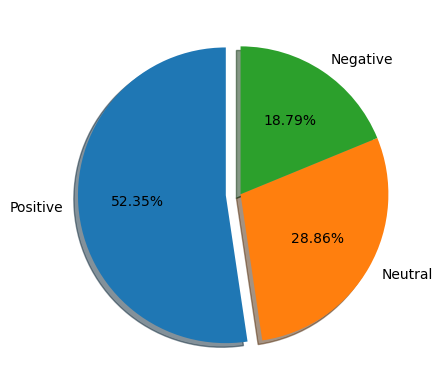

In [54]:
# ploting the value count of analysis
myexplode=[0.1,0,0]
plt.pie(df_senti1["Roberta_Sentiment"],labels=df_senti1["index"],startangle = 90,explode=myexplode,shadow=True,autopct='%1.2f%%')
plt.show()

## Comparing the sentiment in both the TextBlob and Roberta

In [62]:
# Example 1
df["Reviews"][16]

"The touch and other functions are fine but the sound quality is just bad, reason why I'm returning the product."

In [72]:
Text = df["Blob_Sentiment"][16]
rob = df["Roberta_Sentiment"][16]
print(f"Sentiment of TextBlob: {Text}")
print(f"Sentiment of Roberta: {rob}")

Sentiment of TextBlob: positve
Sentiment of Roberta: Negative


### As we see for the above sentence TextBlob give the sentiment as Positive
### But the Roberta Pretrained model gives Negative

In [65]:
# Example 2
df["Reviews"][9]

"In Charging box the left charging point doesn't working and the right side air pods discharging soon.so make any other choice"

In [74]:
Text1 = df["Blob_Sentiment"][9]
rob1 = df["Roberta_Sentiment"][9]
print(f"Sentiment of TextBlob: {Text1}")
print(f"Sentiment of Roberta: {rob1}")

Sentiment of TextBlob: positve
Sentiment of Roberta: Neutral


### Here the TextBlob model gives Positive
### But Roberta Pretrained model gives Neutral

### AS we see the value counts of the TextBlob and Roberta both are different
### These difference are all because of Roberta model not only see the word but also see the context in which that word occur
